<a href="https://colab.research.google.com/github/MoizAhmed2517/Satellite-Image-Semantic-Segmentation/blob/main/Satellite_Remote_Sensing_images_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setting Drive settings

In [1]:
!pip install patchify

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
%cd drive/MyDrive/ColabNotebooks

/content/drive/MyDrive/ColabNotebooks


### Setup datapath

In [4]:
import os
import cv2
import random
from PIL import Image
import numpy as np
from patchify import patchify, unpatchify
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [5]:
def get_images(extension):
  folder = 'satellite_imagery_data'
  images = []
  for path, dir, files in os.walk(folder):
    for file in files:
      if file.lower().endswith(extension):
        images.append(os.path.join(path, file))
  return images

images = get_images('.png')

Original Image Shape: (544, 509, 3)
Padded Image Shape: (640, 512, 3)
Image Patches Shape: (5, 4, 1, 128, 128, 3)
Patch Shape: (128, 128, 3)


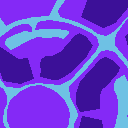

Patch Shape: (128, 128, 3)


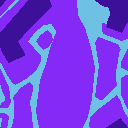

Patch Shape: (128, 128, 3)


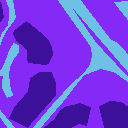

Patch Shape: (128, 128, 3)


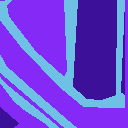

Patch Shape: (128, 128, 3)


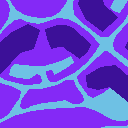

Patch Shape: (128, 128, 3)


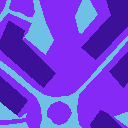

Patch Shape: (128, 128, 3)


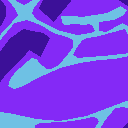

Patch Shape: (128, 128, 3)


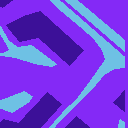

Patch Shape: (128, 128, 3)


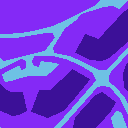

Patch Shape: (128, 128, 3)


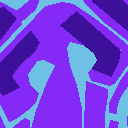

Patch Shape: (128, 128, 3)


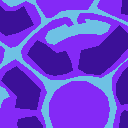

Patch Shape: (128, 128, 3)


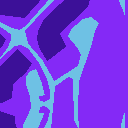

Patch Shape: (128, 128, 3)


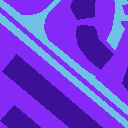

Patch Shape: (128, 128, 3)


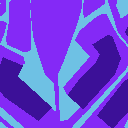

Patch Shape: (128, 128, 3)


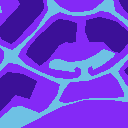

Patch Shape: (128, 128, 3)


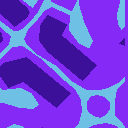

Patch Shape: (128, 128, 3)


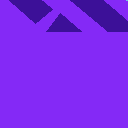

Patch Shape: (128, 128, 3)


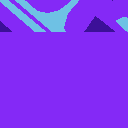

Patch Shape: (128, 128, 3)


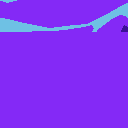

Patch Shape: (128, 128, 3)


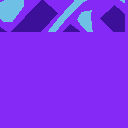

In [6]:
## Padding technique

# Read the image (replace with your image)
image = cv2.imread(images[5], 1)
print("Original Image Shape:", image.shape)

image_patch_size = 128

# Calculate the required padding dimensions to make the image size divisible by patch size
pad_x = (image_patch_size - image.shape[1] % image_patch_size) % image_patch_size
pad_y = (image_patch_size - image.shape[0] % image_patch_size) % image_patch_size

# Pad the image (adding padding to the right and bottom to match patch size)
image_padded = cv2.copyMakeBorder(image, 0, pad_y, 0, pad_x, cv2.BORDER_CONSTANT, value=(246, 41, 132))

print("Padded Image Shape:", image_padded.shape)

# Patchify the image
image_patches = patchify(image_padded, (image_patch_size, image_patch_size, 3), step=image_patch_size)
print("Image Patches Shape:", image_patches.shape)

# Loop through the patches and display them
for i in range(image_patches.shape[0]):
    for j in range(image_patches.shape[1]):
        # Extract a single patch
        single_patch_img = image_patches[i, j, 0, :, :, :]  # Remove the extra dimension
        print("Patch Shape:", single_patch_img.shape)

        # Display the patch
        cv2_imshow(single_patch_img)

In [7]:
mask_data = []
minmax = MinMaxScaler()
# Cropping technique
image = cv2.imread(images[5], 1)
print("Original Image Shape:", image.shape)
image_patch_size = 256

size_x = (image.shape[1] // image_patch_size) * image_patch_size
size_y = (image.shape[0] // image_patch_size) * image_patch_size

image = Image.fromarray(image)
image = image.crop((0, 0, size_x, size_y))
image = np.array(image)
print("Crop Image shape:", image.shape)
image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
print("Image patches shape:", image_patches.shape)

# getting patch of images:

for i in range(image_patches.shape[0]):
  for j in range(image_patches.shape[1]):
    single_patch_img = image_patches[i, j, :, :]
    print(single_patch_img[0].shape)
    img_patch = single_patch_img[0]
    print("Normalized Image:", img_patch.shape)

Original Image Shape: (544, 509, 3)
Crop Image shape: (512, 256, 3)
Image patches shape: (2, 1, 1, 256, 256, 3)
(256, 256, 3)
Normalized Image: (256, 256, 3)
(256, 256, 3)
Normalized Image: (256, 256, 3)


In [8]:
def preprocess_images(images, train_dataset=True):
  image_patch_size = 256
  dataset = []
  minmax = MinMaxScaler()
  for img in images:
    image = cv2.imread(img, 1)
    if not train_dataset:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_x = (image.shape[1] // image_patch_size) * image_patch_size
    size_y = (image.shape[0] // image_patch_size) * image_patch_size
    image = Image.fromarray(image)
    image = image.crop((0, 0, size_x, size_y))
    image = np.array(image)
    image_patches = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
    for i in range(image_patches.shape[0]):
      for j in range(image_patches.shape[1]):
        single_patch_img = image_patches[i, j, :, :]
        if train_dataset:
          img_patch = minmax.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
          img_patch = img_patch[0]
        else:
          img_patch = single_patch_img[0]
        dataset.append(img_patch)
  return dataset

In [9]:
images = get_images('.jpg')
image = preprocess_images(images)
masks = get_images('.png')
mask = preprocess_images(masks, False)

In [10]:
image_dataset = np.array(image)
mask_dataset = np.array(mask)

In [11]:
len(image), len(mask)

(1305, 1305)

#### processing Labels using one hot encoding

In [12]:
def mask_encoding(hex_code):
  return np.array(tuple(int(hex_code[i:i+2], 16) for i in (0, 2, 4)))

In [13]:
Building = '#3C1098'.lstrip('#')
Building = mask_encoding(Building)

Land = '#8429F6'.lstrip('#')
Land = mask_encoding(Land)

Road = '#6EC1E4'.lstrip('#')
Road = mask_encoding(Road)

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = mask_encoding(Vegetation)

Water = 'E2A929'.lstrip('#')
Water = mask_encoding(Water)

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = mask_encoding(Unlabeled)

In [14]:
Building

array([ 60,  16, 152])

In [15]:
mask_dataset.shape

(1305, 256, 256, 3)

In [16]:
def rgb_to_label(label):
  label_seg = np.zeros(label.shape, dtype=np.uint8)
  label_seg[np.all(label == Building, axis=-1)] = 0
  label_seg[np.all(label == Land, axis=-1)] = 1
  label_seg[np.all(label == Road, axis=-1)] = 2
  label_seg[np.all(label == Vegetation, axis=-1)] = 3
  label_seg[np.all(label == Water, axis=-1)] = 4
  label_seg[np.all(label == Unlabeled, axis=-1)] = 5
  label_seg = label_seg[:, :, 0]
  return label_seg

In [17]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [18]:
labels = np.array(labels)

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4],
       [1, 1, 1, ..., 4, 4, 4]], dtype=uint8)
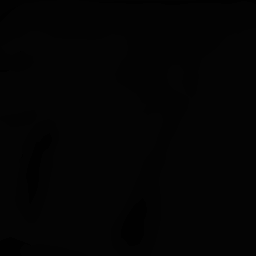

In [19]:
labels[3]

In [20]:
labels = np.expand_dims(labels, axis=3)

In [21]:
labels[3]

array([[[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       [[2],
        [2],
        [2],
        ...,
        [1],
        [1],
        [1]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [4],
        [4],
        [4]],

       [[1],
        [1],
        [1],
        ...,
        [4],
        [4],
        [4]],

       [[1],
        [1],
        [1],
        ...,
        [4],
        [4],
        [4]]], dtype=uint8)

In [22]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [23]:
def random_image_comparison_plot(image, mask, labels=False):
  id = random.randint(0, len(image))
  plt.figure(figsize=(10, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(image[id])
  plt.subplot(1, 2, 2)
  if labels:
    plt.imshow(mask[id][:, :, 0])
  else:
    plt.imshow(mask[id])

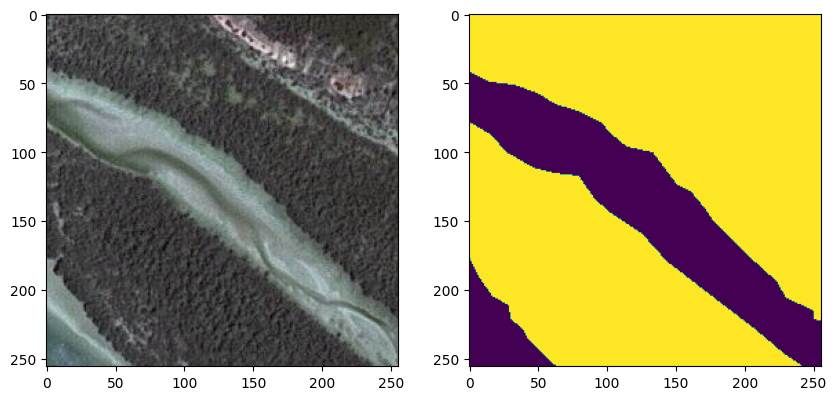

In [24]:
random_image_comparison_plot(image_dataset, labels, True)

In [25]:
total_classes = len(np.unique(labels))

In [26]:
label_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [27]:
label_categorical_dataset.shape

(1305, 256, 256, 6)

In [28]:
master_training_dataset = image_dataset

In [29]:
master_training_dataset.shape

(1305, 256, 256, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, label_categorical_dataset, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape), print(X_test.shape), print(y_train.shape), print(y_test.shape)